In [1091]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import statsmodels.api as sm
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt  

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from pandas_profiling import ProfileReport
from scipy.stats import boxcox

from copy import copy, deepcopy

In [1092]:
def removeOutliers(train_orig):
    if('SalePrice' in train_orig.columns):
        fig, ax =plt.subplots(1,2,figsize=(10,4))
        sns.scatterplot(x='GrLivArea',y='SalePrice',data=train_orig,ax=ax[0])
        sns.scatterplot(x='GrLivArea',y='SalePrice',data=train_orig[train_orig['GrLivArea']<4000],ax=ax[1])
        fig.show()
    train_orig=train_orig[train_orig['GrLivArea']<4000]
    return(train_orig)

/Users/shaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


training data size =  (1456, 81)


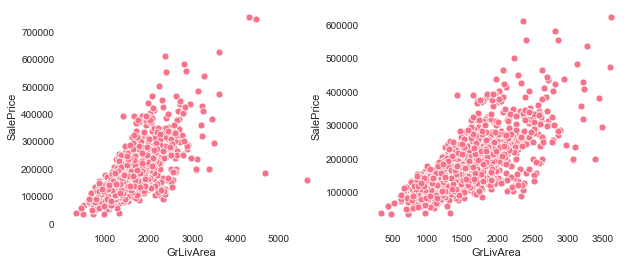

In [1093]:
train_orig = pd.read_csv( "/Users/shaan/Downloads/DataSet/train.csv" )
train_orig=pd.DataFrame(train_orig)
train_orig=removeOutliers(train_orig)#remove outliers
print("training data size = ", train_orig.shape)
Y_train=deepcopy(train_orig["SalePrice"])
#train=train_orig.drop(['SalePrice'],axis=1)
test_orig = pd.read_csv( "/Users/shaan/Downloads/DataSet/test.csv" )
test_orig=pd.DataFrame(test_orig)
#test_orig=removeOutliers(test_orig)#remove outliers

### handle missing values


In [1094]:
Y_orig_=deepcopy(train_orig['SalePrice'])
train_size=len(train_orig)
data=deepcopy(train_orig)
data.drop(['SalePrice'],axis=1,inplace=True)
data=deepcopy(data.append(test_orig,sort=False))
data.drop(['Id'],axis=1,inplace=True)
print(data.shape)

(2915, 79)


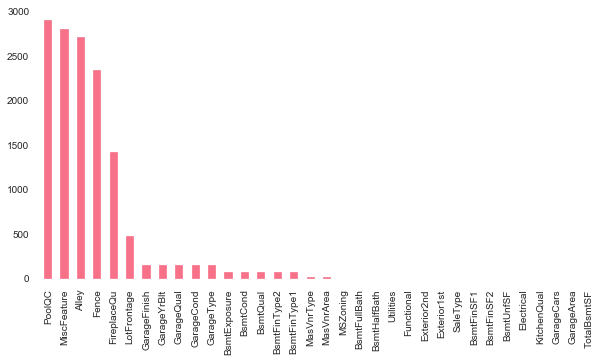

In [1095]:
all_data_na = data.isnull().sum()
# get rid of all the values with 0 missing values
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
plt.subplots(figsize =(10, 5))
all_data_na.plot(kind='bar');

In [1096]:
#find out columns with missing values
nullCols=data.columns[data.isna().any()].tolist()
print("Columns with nulls: ", nullCols)

zeros = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath',\
        'BsmtHalfBath','GarageYrBlt','GarageCars','GarageArea']
stringNA = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',\
            'FireplaceQu','GarageType','GarageFinish','GarageQual', 'GarageCond', 'PoolQC',\
            'Fence', 'MiscFeature','FireplaceQu']
stringNone = ['MasVnrType']
recheck = ['LotFrontage']
mode = ['MSZoning','Exterior1st','Exterior2nd','Electrical','KitchenQual','Functional',\
        'SaleType']
dropCols=['Utilities']
#b=set(train_orig['YearBuilt'])
#print(b)
#print(all_data_na['YearBuilt'])

Columns with nulls:  ['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [1097]:
data[stringNA]=data[stringNA].fillna('NA')
data[stringNone]=data[stringNone].fillna('None')
data[zeros]=data[zeros].fillna(0)
data.drop(dropCols,axis=1,inplace=True)
data['LotFrontage']=data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
for col in mode:
    data[col]=data[col].fillna(data[col].mode()[0])

In [1098]:
print('Total Nulls left:',sum(np.sum(data.isnull())))

Total Nulls left: 0


### Polynomial Features

In [1099]:
def get_non_linear_features(train):
    y=train['SalePrice']
    corr={}    
    train=train.select_dtypes(exclude='object').copy()
    #train=train.drop(numericalCatColumns, axis=1)
    for x in train.columns:
        if(x=='SalePrice' or 'Year'in x):
            continue
        correlation=np.corrcoef(train[x],y)[0][1]
        if not math.isnan(correlation):
            corr[x]=correlation
    return  corr

In [1100]:
def makepolyCols(train,polyCols):
    for col in polyCols:
        train[col+"_sqr"]=np.power(train[col],2)
        train[col+"_cub"]=np.power(train[col],3)
        train[col+"_root"]=np.sqrt(train[col])
    return train

In [1101]:
#add non-linear columns
n=20
train_orig_new=deepcopy(data[:train_size])
train_orig_new['SalePrice']=Y_orig_
Corr=get_non_linear_features(deepcopy(train_orig_new))
Corr={k: v for k, v in sorted(Corr.items(), key=lambda item: item[1],reverse=True)[0:n]}
polyCols=Corr.keys()
print('Chosen polynomial features',polyCols)
print('number of poly features =',len(polyCols))

Chosen polynomial features dict_keys(['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'OpenPorchSF', 'WoodDeckSF', '2ndFlrSF', 'HalfBath', 'LotArea', 'GarageYrBlt', 'BsmtFullBath', 'BsmtUnfSF'])
number of poly features = 20


In [1102]:
#make polynomial featues
data_poly=makepolyCols(deepcopy(data),polyCols)

In [1103]:
#split back
train_orig_new=deepcopy(data_poly[:train_size])
train_orig_new['SalePrice']=Y_orig_
test_orig_new=deepcopy(data_poly[train_size:len(data_poly)])
print("training data shape = ",train_orig_new.shape)
print("test data shape = ",test_orig_new.shape)

training data shape =  (1456, 139)
test data shape =  (1459, 138)


### SAVE CLEANED DATA

In [1104]:
train_orig_new.to_csv('train_cleaned.csv',index=False)
test_orig_new.to_csv('test_cleaned.csv',index=False)

In [1105]:
train_orig_new_new=deepcopy(data)
print(train_orig_new_new.shape)

(2915, 78)


### Process features

In [1106]:
#original
a=np.array(data.columns)
done=['BsmtQual','BsmtCond','BsmtExposure','1stFlrSF','KitchenQual','TotRmsAbvGrd',\
      'Fireplaces','FireplaceQu','OverallQual','OverallCond','Functional',\
     'Exterior2nd','ExterQual','ExterCond','GarageFinish','GarageCars','GarageQual',\
      'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','Condition2',\
      'Street','Heating','HeatingQC','CentralAir','Electrical','SaleType'
     ]#Exterior2nd,Condition2 handled specially, GarageFinish might be better as dummy
dummy=['BsmtFinType1','BsmtFinType2','BldgType','HouseStyle','RoofStyle','MasVnrType',\
       'GarageType','Exterior1st','RoofMatl','Foundation','GarageCond','Fence','MSZoning',\
      'Neighborhood','Condition1','LotShape','LotShape','LandContour','LotConfig','LandSlope',\
      'Alley','PavedDrive','SaleCondition']
num2str=['BedroomAbvGr','KitchenAbvGr','MSSubClass','MoSold','YrSold']#check
zeroflag=['BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','2ndFlrSF','LowQualFinSF',\
          'YearRemodAdd','WoodDeckSF']#YearRemodAdd is changed to YearRemodAdd-YrBuilt
boxcoxCols=['GrLivArea','GarageArea','LotFrontage','LotArea']
dropCols=['BsmtUnfSF','FullBath','HalfBath','BsmtHalfBath','BsmtFullBath','MasVnrArea','PoolQC',\
         'MiscFeature','MiscVal']#recheck,maybe add:LowQualFinSF
binned=['YearBuilt','GarageYrBlt']#possible:1stFlrSF,2ndFlrSF, recheck binning
done=done+dummy+binned+zeroflag+dropCols+num2str+boxcoxCols
print(np.setdiff1d(a,done))
print('original:',len(a))
print('left:',len(np.setdiff1d(a,done)))

[]
original: 78
left: 0


In [1107]:
#new testing
a=np.array(data.columns)
done=['BsmtQual','BsmtCond','BsmtExposure','1stFlrSF','KitchenQual','TotRmsAbvGrd',\
      'Fireplaces','FireplaceQu','OverallQual','OverallCond','Functional',\
     'Exterior2nd','ExterQual','ExterCond','GarageFinish','GarageCars','GarageQual',\
      'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','Condition2',\
      'Street','Heating','HeatingQC','CentralAir','Electrical','SaleType','MoSold','BsmtUnfSF',\
      'MiscFeature','MasVnrArea'
     ]#Exterior2nd,Condition2 handled specially, GarageFinish might be better as dummy
dummy=['BsmtFinType1','BsmtFinType2','BldgType','HouseStyle','RoofStyle','MasVnrType',\
       'GarageType','Exterior1st','RoofMatl','Foundation','GarageCond','Fence','MSZoning',\
      'Neighborhood','Condition1','LotShape','LotShape','LandContour','LotConfig','LandSlope',\
      'Alley','SaleCondition','PavedDrive']
num2str=['BedroomAbvGr','KitchenAbvGr','MSSubClass','YrSold']#check
zeroflag=['BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','2ndFlrSF','LowQualFinSF',\
          'YearRemodAdd','WoodDeckSF']#YearRemodAdd is changed to YearRemodAdd-YrBuilt
boxcoxCols=['GrLivArea','GarageArea','LotFrontage','LotArea']
dropCols=['FullBath','HalfBath','BsmtHalfBath','BsmtFullBath','PoolQC',\
         'MiscVal']#recheck,maybe add:LowQualFinSF
binned=['YearBuilt','GarageYrBlt']#possible:1stFlrSF,2ndFlrSF, recheck binning
done=done+dummy+binned+zeroflag+dropCols+num2str+boxcoxCols
print(np.setdiff1d(a,done))
print('original:',len(a))
print('left:',len(np.setdiff1d(a,done)))

[]
original: 78
left: 0


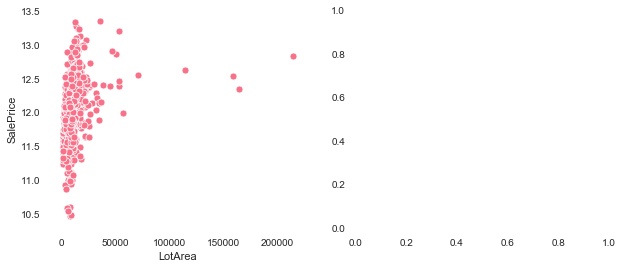

In [1108]:
#analyse individual features
col='LotArea'
train_orig1=deepcopy(train_orig_new)
train_orig1['SalePrice']=deepcopy(np.log(train_orig1['SalePrice']))
#train_orig1[col]=deepcopy(np.log(train_orig1[col]+1))
#l,opt = boxcox(train_orig1[col]+1)
#train_orig1[col]=deepcopy(boxcox(train_orig1[col]+1,lmbda=opt))

#train_orig1['remod']=train_orig1['YearRemodAdd']-train_orig1['YearBuilt']
fig,ax=plt.subplots(1,2,figsize=(10,4))
sns.set_palette('husl')
sns.scatterplot(x=col,y='SalePrice',data=train_orig1,ax=ax[0])
#sns.stripplot(x=col,y='SalePrice',data=train_orig1,ax=ax[0])

#sns.boxplot(x=col,y='SalePrice',data=train_orig1,ax=ax[1])
#sns.distplot(train_orig1[col],ax=ax[1])

#print(sum(train_orig1[col]==0))
#print(sum(train_orig1['MasVnrType']=='None'))
#print((data[col].value_counts()))

In [1109]:
#other manipulations
#BATH
train_orig_new_new['TotalBaths']=train_orig_new_new['FullBath']+\
train_orig_new_new['BsmtHalfBath']+\
train_orig_new_new['BsmtFullBath']+train_orig_new_new['HalfBath']#added a col here

#'''
train_orig_new_new['HouseStyle']=train_orig_new_new['HouseStyle'].replace('2.5Unf','2.5Story')
train_orig_new_new['HouseStyle']=train_orig_new_new['HouseStyle'].replace('2.5Fin','2.5Story')
print('HouseStyle Values:',set(train_orig_new_new['HouseStyle']))
#'''
train_orig_new_new['Exterior2nd']=list(map(int,train_orig_new_new['Exterior1st']!=train_orig_new_new['Exterior2nd']))
train_orig_new_new['GarageYrBlt']=train_orig_new_new['GarageYrBlt'].replace(2207,2007)

#'''
GarageCondDic={'NA':'NA','Po':'Low','Fa':'Low','TA':'TA','Gd':'High','Ex':'High'}
train_orig_new_new['GarageCond']=train_orig_new_new['GarageCond'].map(GarageCondDic)
print('GarageCond Values:',set(train_orig_new_new['GarageCond']))
#'''

#PORCH
train_orig_new_new['TotalPorchArea']=train_orig_new_new['OpenPorchSF']+train_orig_new_new['EnclosedPorch']+\
train_orig_new_new['3SsnPorch']+train_orig_new_new['ScreenPorch']#added a col here
train_orig_new_new['TotalPorchArea']=np.log(train_orig_new_new['TotalPorchArea']+1)
PorchCols = ['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']
for col in PorchCols:
    train_orig_new_new[col]=train_orig_new_new[col].map(lambda x: 1 if (x>0) else 0)
train_orig_new_new["TotalPorchArea_is0"]=list(map(int,train_orig_new_new['TotalPorchArea']==0))#added a col here

#flags 
train_orig_new_new["PoolArea"]=list(map(int,train_orig_new_new['PoolArea']!=0))
train_orig_new_new["Street"]=list(map(int,train_orig_new_new['Street']!='Grvl'))
train_orig_new_new["Heating"]=list(map(int,train_orig_new_new['Heating']=='GasA'))
train_orig_new_new["Condition2"]=list(map(int,train_orig_new_new['Condition2']!=train_orig_new_new['Condition1']))
#'''
LotConfigDic={'Inside':'Inside','Corner':'Corner','CulDSac':'CulDSac','FR2':'FR','FR3':'FR'}
train_orig_new_new['LotConfig']=train_orig_new_new['LotConfig'].map(LotConfigDic)
print('LotConfig Values:',set(train_orig_new_new['LotConfig']))

LandSlopeDic={'Gtl':'Gtl','Mod':'Mod','Sev':'Mod'}
train_orig_new_new['LandSlope']=train_orig_new_new['LandSlope'].map(LandSlopeDic)
print('LandSlope Values:',set(train_orig_new_new['LandSlope']))

SaleTypeDic={'COD':'COD', 'CWD':'WD', 'Con':'Oth', 'ConLD':'Oth', 'ConLI':'Oth',\
             'ConLw':'Oth', 'New':'New', 'Oth':'Oth', 'WD':'WD'}
train_orig_new_new['SaleType']=train_orig_new_new['SaleType'].map(SaleTypeDic)
print('SaleType Values:',set(train_orig_new_new['SaleType']))
#'''

print('shape after manipulation: ',train_orig_new_new.shape)

HouseStyle Values: {'1.5Unf', '2Story', 'SFoyer', '1Story', '1.5Fin', '2.5Story', 'SLvl'}
GarageCond Values: {'NA', 'Low', 'High', 'TA'}
LotConfig Values: {'Corner', 'Inside', 'FR', 'CulDSac'}
LandSlope Values: {'Mod', 'Gtl'}
SaleType Values: {'Oth', 'COD', 'New', 'WD'}
shape after manipulation:  (2915, 81)


In [1110]:
print(zeroflag)
for col in zeroflag:
    train_orig_new_new[col+"_is0"]=list(map(int,train_orig_new_new[col]==0))
    assert(sum(train_orig_new_new[col+"_is0"])==sum(train_orig_new_new[col]==0))
    
#keep only flags for these
zerodrop=['BsmtFinSF2','LowQualFinSF']
train_orig_new_new.drop(zerodrop,axis=1,inplace=True)
print('columns added=',len(zeroflag)-len(zerodrop))
print('shape after zero flags: ',train_orig_new_new.shape)

['BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'YearRemodAdd', 'WoodDeckSF']
columns added= 5
shape after zero flags:  (2915, 86)


In [1111]:
OrdinalFeatureMap={}
BsmtQualDic={'NA':0,'Fa':1,'TA':2,'Gd':3,'Ex':4}
BsmtCondDic={'Po':0,'NA':1,'Fa':2,'TA':3,'Gd':4}#check. Can make dummy too
BsmtExposureDic={'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4}
KitchenQualDic={'NA':0,'Fa':1,'TA':2,'Gd':3,'Ex':4}
FireplaceQuDic={'Po':1,'NA':0,'Fa':2,'TA':3,'Gd':4,'Ex':5}
FunctionalDic={'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7}
ExterQualDic={'NA':0,'Fa':1,'TA':2,'Gd':3,'Ex':4}
ExterCondDic={'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
GarageFinishDic={'NA':0,'Unf':1,'RFn':2,'Fin':3}
GarageQualDic={'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
HeatingQCDic={'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
CentralAirDic={'Y':1,'N':0}
ElectricalDic={'NA':0,'Mix':1,'FuseP':2,'FuseF':3,'FuseA':4,'SBrkr':5}

OrdinalFeatureMap['BsmtQual']=BsmtQualDic
OrdinalFeatureMap['BsmtCond']=BsmtCondDic
OrdinalFeatureMap['BsmtExposure']=BsmtExposureDic
OrdinalFeatureMap['KitchenQual']=KitchenQualDic
OrdinalFeatureMap['FireplaceQu']=FireplaceQuDic
OrdinalFeatureMap['Functional']=FunctionalDic
OrdinalFeatureMap['ExterQual']=ExterQualDic
OrdinalFeatureMap['ExterCond']=ExterCondDic
OrdinalFeatureMap['GarageFinish']=GarageFinishDic
OrdinalFeatureMap['GarageQual']=GarageQualDic
OrdinalFeatureMap['HeatingQC']=HeatingQCDic
OrdinalFeatureMap['CentralAir']=CentralAirDic
OrdinalFeatureMap['Electrical']=ElectricalDic


print("values after mapping")
for col,dic in OrdinalFeatureMap.items():
    train_orig_new_new[col]=train_orig_new_new[col].map(dic)
    print(col,":",set(train_orig_new_new[col]))

print('shape after mapping values: ',train_orig_new_new.shape)

values after mapping
BsmtQual : {0, 1, 2, 3, 4}
BsmtCond : {0, 1, 2, 3, 4}
BsmtExposure : {0, 1, 2, 3, 4}
KitchenQual : {1, 2, 3, 4}
FireplaceQu : {0, 1, 2, 3, 4, 5}
Functional : {1, 2, 3, 4, 5, 6, 7}
ExterQual : {1, 2, 3, 4}
ExterCond : {1, 2, 3, 4, 5}
GarageFinish : {0, 1, 2, 3}
GarageQual : {0, 1, 2, 3, 4, 5}
HeatingQC : {1, 2, 3, 4, 5}
CentralAir : {0, 1}
Electrical : {1, 2, 3, 4, 5}
shape after mapping values:  (2915, 86)


In [1112]:
#log transform
maybe=['BsmtFinSF1','2ndFlrSF']#try with and without
logs=['BsmtUnfSF','TotalBsmtSF','1stFlrSF','WoodDeckSF','PoolArea']
logs=logs+maybe
for col in logs:
    train_orig_new_new[col]=deepcopy(np.log(train_orig_new_new[col]+1))

In [1113]:
#boxcox transform
for col in boxcoxCols:
    _,opt = boxcox(train_orig_new_new[col]+1)
    train_orig_new_new[col]=deepcopy(boxcox(train_orig_new_new[col]+1,lmbda=opt))

In [1114]:
#drop Cols
train_orig_new_new.drop(dropCols,axis=1,inplace=True)
print("dropping #cols=",len(dropCols))
print('shape after dropping: ',train_orig_new_new.shape)

dropping #cols= 6
shape after dropping:  (2915, 80)


In [1115]:
n=8
quantiles_=np.linspace(0,1,n+1)
quantiles_[0]=0.02
quantiles_=np.insert(quantiles_,0,0)
quantiles=(train_orig_new_new['YearBuilt'].quantile(quantiles_))
print(quantiles)
#quantiles=(train_orig_new['YearBuilt'].quantile(quantiles_))
#print(quantiles)
#sns.distplot(train_orig_new_new['YearBuilt'])
#sns.scatterplot(x='YearBuilt',y='SalePrice',data=train_orig_new)
#for q in quantiles:
#    plt.axvline(q)
train_orig_new_new['YearBuilt_qcut'] = pd.qcut(train_orig_new_new['YearBuilt'], q=quantiles_,precision=0)
train_orig_new_new['YearBuilt_qcut'] = train_orig_new_new['YearBuilt_qcut'].map(lambda x:str(x).replace(', ','_').replace('(','').replace(']','').replace('.0',''))

print('bins:',set(train_orig_new_new['YearBuilt_qcut']))
train_orig_new_new.drop(['YearBuilt'],axis=1,inplace=True)
print('shape after binning: ',train_orig_new_new.shape)

0.000    1872.00
0.020    1904.28
0.125    1929.00
0.250    1953.00
0.375    1963.00
0.500    1973.00
0.625    1990.00
0.750    2001.00
0.875    2005.00
1.000    2010.00
Name: YearBuilt, dtype: float64
bins: {'1871_1904', '1904_1929', '1990_2001', '2005_2010', '1973_1990', '1953_1963', '1963_1973', '1929_1953', '2001_2005'}
shape after binning:  (2915, 80)


In [1116]:
n=8
quantiles_=np.linspace(0,1,n+1)
quantiles=(train_orig_new_new['GarageYrBlt'].quantile(quantiles_))
print(quantiles)
#sns.distplot(train_orig_new_new['YearBuilt'])
#sns.scatterplot(x='YearBuilt',y='SalePrice',data=train_orig_new)
#for q in quantiles:
#    plt.axvline(q)

   
train_orig_new_new['GarageYrBlt_qcut'] = pd.qcut(train_orig_new_new['GarageYrBlt'], q=quantiles_,precision=0)
train_orig_new_new['GarageYrBlt_qcut'] = train_orig_new_new['GarageYrBlt_qcut'].map(lambda x:str(x).replace(', ','_').replace('(','').replace(']','').replace('.0',''))
print('bins:',set(train_orig_new_new['GarageYrBlt_qcut']))
train_orig_new_new.drop(['GarageYrBlt'],axis=1,inplace=True)
print('shape after binning: ',train_orig_new_new.shape)

0.000       0.00
0.125    1937.25
0.250    1957.00
0.375    1967.00
0.500    1977.00
0.625    1993.00
0.750    2001.00
0.875    2005.00
1.000    2010.00
Name: GarageYrBlt, dtype: float64
bins: {'2001_2005', '1967_1977', '1937_1957', '2005_2010', '1957_1967', '1993_2001', '-1_1937', '1977_1993'}
shape after binning:  (2915, 80)


In [1117]:
#TESTING
binningCols=[]
for col in binningCols:
    n=8
    quantiles_=np.linspace(0,1,n+1)
    quantiles=(train_orig_new_new[col].quantile(quantiles_))
    train_orig_new_new[col+'_qcut'] = pd.qcut(train_orig_new_new[col], q=quantiles_,precision=0)
    train_orig_new_new[col+'_qcut'] = train_orig_new_new[col+'_qcut'].map(lambda x:str(x).replace(', ','_').replace('(','').replace(']','').replace('.0',''))
    #print('bins:',set(train_orig_new_new[col+'_qcut']))
    #train_orig_new_new.drop([col],axis=1,inplace=True)
    print('shape after binning'+col+': ',train_orig_new_new.shape)

In [1118]:
#numeric to string
for col in num2str:
    train_orig_new_new[col]=list(map(str,train_orig_new_new[col]))

### TODO:
* check log transform columns
* check if these can be dropped: BsmtFinSF2,BsmtUnfSF/TotalBsmtSF
* why flag for BsmtFinSF2
* Recheck distributios of:1stFlrSF,2ndFlrSF
* figure out something about 6 bathrooms in TotalBaths
* recheck BedroomAbvGr,MSSubClass(can cluster a few),OverallCond(cane make dummy),Foundation(make ordinal?),GarageFinish(keep as dummy?),GarageQual,MSZoning(can be ordinal),Condition2,PavedDrive(can be ordinal)
* drop some dummies in RoofMatl
* try keeping MasVnrArea
* TotalPorchArea seems irrelevant
* LotFrontage - how to scale best
* why not drop PoolArea
* can check dummy for MiscFeature
* WHY MoSold is DUMMY??! Could be a non linear relationship. Values tend to get bigger in midyears
* experiment more with SaleType

In [1119]:
#add non-linear columns
RemCols=list(set(train_orig_new_new.columns) & set(polyCols))
print(RemCols)
print(np.setdiff1d(list(polyCols),list(RemCols)))
RemCols.append('TotalBaths')

['BsmtUnfSF', 'MasVnrArea', 'LotFrontage', 'OpenPorchSF', 'TotRmsAbvGrd', '2ndFlrSF', 'GarageArea', 'TotalBsmtSF', 'GrLivArea', 'Fireplaces', 'GarageCars', '1stFlrSF', 'OverallQual', 'LotArea', 'WoodDeckSF', 'BsmtFinSF1']
['BsmtFullBath' 'FullBath' 'GarageYrBlt' 'HalfBath']


In [1120]:
#make polynomial featues again
data_poly_new=makepolyCols(deepcopy(train_orig_new_new),RemCols)

In [1121]:
#split back
train_orig_final=deepcopy(data_poly_new[:train_size])
train_orig_final['SalePrice']=Y_orig_
test_orig_final=deepcopy(data_poly_new[train_size:len(data_poly_new)])
print("training data shape = ",train_orig_final.shape)
print("test data shape = ",test_orig_final.shape)

training data shape =  (1456, 132)
test data shape =  (1459, 131)


In [1122]:
#check if dummy features are indeed dummy
nonCategoricalData=deepcopy(train_orig_new_new.select_dtypes(include='object'))
nonCategoricalDataCols=nonCategoricalData.columns
dummy=dummy+num2str
for col in dummy:
    if col not in list(nonCategoricalDataCols):
        print(col, " is not dummy" )

### SAVE CLEANED DATA

In [1123]:
train_orig_final.to_csv('train_cleaned.csv',index=False)
test_orig_final.to_csv('test_cleaned.csv',index=False)